# DSCI 100 Project Report
## Predicting time windows with high-demand usage for efficient allocation of licenses
### Introduction
Over the past few decades, digital technology has advanced more rapidly than any other human innovation and has reached the point where our society is almost completely dependent on it. The increasing volume of data, as a consequence of such advancement, has made data science one of the fastest growing fields across every industry(IBM, 2021). <br>

A popular field where the importance of data science has skyrocketed is the gaming industry. With the use of data, developers can identify patterns and preferences, enabling them to enhance the gaming experience for players(Whitehead, 2024). Data science helps gaming companies develop "effective monetisation strategies" (Whitehead, 2024) by examining the spending patterns of the players and forecasting their behaviour. In this project, I used data science methods to explore a dataset, extracted from the Minecraft server, in an attempt to predict the time windows where player activity patterns are high. Using these predictions will allow better allocation of server licenses. The data, collected by a research group in Computer Science led by Frank Wood at UBC Point Grey Campus, will be used to answer the question: Which day of the week is a player most likely to log on based on their age, gender and experience? <br>
 

This predictive analysis will help companies understand player usage patterns and allow them to determine the allocation of licenses during different time windows throughout the week. To answer the question, two datasets were used: players.csv and sessions.csv. These datasets were merged using a common identifier, hashedEmail, to be able to view player characteristics along with their session timings. <br><br>
##### Dataset 1: Player Details (players.csv) <br>
This dataset contains information about the players registered with the Minecraft server. Each row represents observations about a unique player.<br>
Number of observations - 196<br>
Number of variables - 7<br><br>
##### Dataset 2: Session Details (sessions.csv) <br>
This dataset contains information about the players' sessions along with the start and end of session timestamp<br>
Number of observations - 1534<br>
Number of variables - 5<br><br>
##### Variables <br>
1. hashedEmail(chr): A unique, anonymized identifier for each player, containing encrypted email addresses to protect their privacy.<br>
2. name(chr): The name of the players registered with the server<br>
3. gender(chr): The players' self identified gender (Male, Female, Non-binary, Two-Spirited, Prefer not to say, Agender, Other)<br>
4. experience(chr): Player's experience level (Beginner, Amateur, Regular, Pro, Veteran)<br>
5. Age(dbl): Age of the player. (Age range is from 8-50)<br>
6. subscribe(lgl): Whether the player has subscribed to the newsletter or not. (TRUE/FALSE)<br>
7. played_hours(dbl): Total hours played by a player (ranging from 0 - 225)<br>
8. start_time(chr) - timestamp for the start of each player's session (reported as date and time - Day/Month/Year Hour:Minute)<br>
9. end_time(chr) - timestamp for the end of each player's session (reported as date and time - Day/Month/Year Hour:Minute)<br>
10. original_start_time(dbl)- session start time stamp reported in milliseconds<br>
11. original_end_time(dbl)- session end time stamp reported in milliseconds<br>

Data Summary characteristics - 
- Most of the players reported their gender as male.
- The mean age of players is around 20.52 years, with most players being around 19 years of age.
- Most of the players are at the Amateur experience level(63), while only 14 players are at the Pro experience level.
  

### Methods & Results
I started by loading all the relevant packages needed and then load the 2 datasets using read_csv() function from the readr package. After that, I merged the datasets by PlayerID(the common variable between the 2 datasets) to compare the relevant variables side by side. 

##### Loading the Data and setting seed value 

In [1]:
### Loading the Data and setting seed value 
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(ggplot2)
#setting seed 
set.seed(26)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

##### Import the datasets

In [2]:
# Importing the data sets  

#Data set 1 - players (A list of all unique players, including data about each player)
players <- read_csv("data/players.csv")
#Data set 2 - sessions (A list of individual play sessions by each player, including data about the session.)
session <- read_csv("data/sessions.csv")

# Merge datasets using hashedEmail
combined_data <- merge(players, session, by = "hashedEmail") 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### Data Cleaning and Wrangling
I manipulated the data by changing the time-related variables to appropriate weekday format using the fucntions from the lubridate package within the tidyverse metapackage. I also clean the data by removing missing values (na) as these could hinder my analysis and produce inaccurate results.

In [3]:
# converting start and end time from Day/Month/Year Hour:Minute format to days of the week 
combined_data_weekdays <- combined_data |>
mutate( start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time),
    start_day_of_week = wday(start_time, label = TRUE, abbr = FALSE), 
    end_day_of_week = wday(end_time, label = TRUE, abbr = FALSE))

# Selecting and modifying columns
polished_data <- combined_data_weekdays |>
        mutate(gender = as_factor(gender), experience = as_factor(experience)) |>
        select(gender, experience, Age, start_day_of_week) 

# Remove missing values
# Missing Data: Some players have missing  information (e.g., age or gender). These rows were removed before model fitting
polished_data <- polished_data |> drop_na()


##### Summary Statistics
I summarized the data to look at various data trends and statistics.

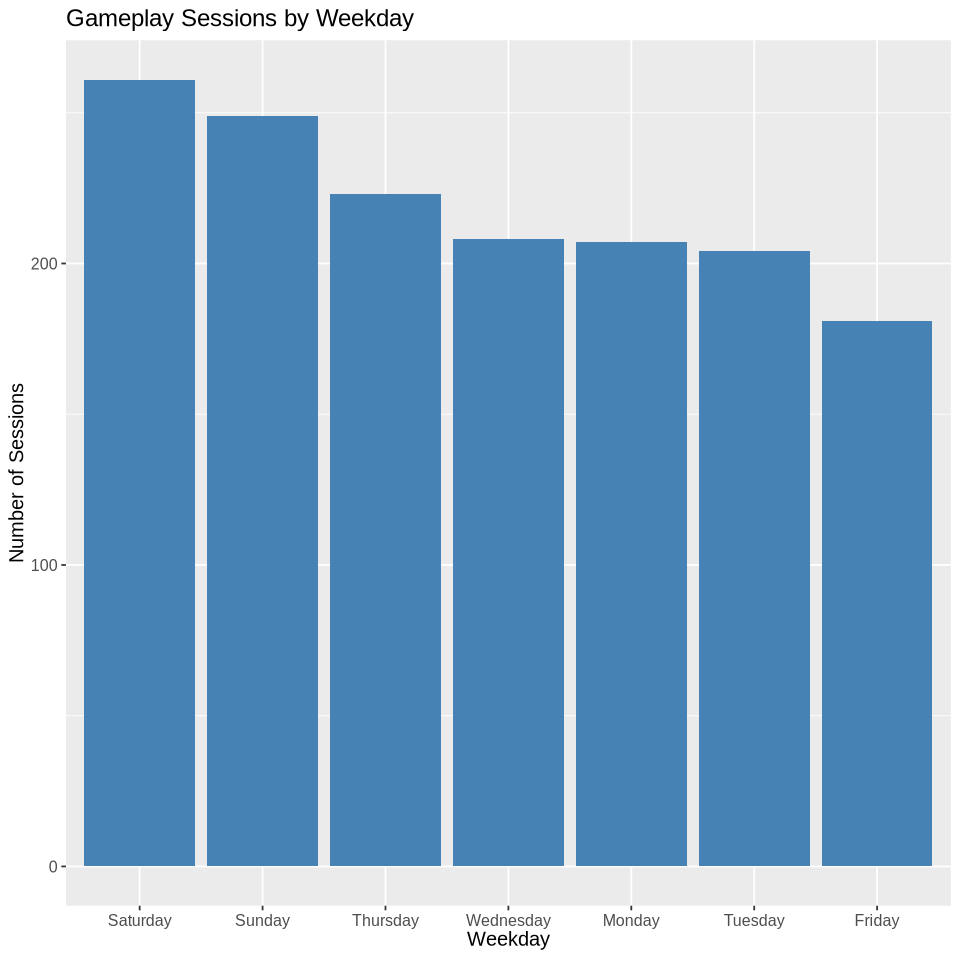

In [4]:
# Summary of Age
players_summary <- polished_data |>
  summarize(
    n_players = n(),
    min_age = min(Age, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    sd_age = sd(Age, na.rm = TRUE))


# Summary by Gender and Experience
gender_summary <- polished_data |>
  group_by(gender) |>
  summarize(count = n())

experience_summary <- polished_data |>
  group_by(experience) |>
  summarize(count = n())

# Sessions by Weekday
weekday_activity <- polished_data |>
  count(start_day_of_week, sort = TRUE)

############################ Plot
weekday_summary <- polished_data |>
  group_by(start_day_of_week) |>                
  summarise(session_count = n()) |>   
  arrange(desc(session_count))  

options(repr.plot.width = 8, repr.plot.height = 8)
weekday_summary_plot <- ggplot(weekday_summary, aes(x = reorder(start_day_of_week, -session_count), y = session_count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Gameplay Sessions by Weekday",
       x = "Weekday",
       y = "Number of Sessions") +
  theme(text = element_text(size = 12))
weekday_summary_plot

##### Model Building: K-Nearest Neighbours (KNN) Classification
 I used a K-Nearest Neighbors (KNN) classification model to answer my predictive question.

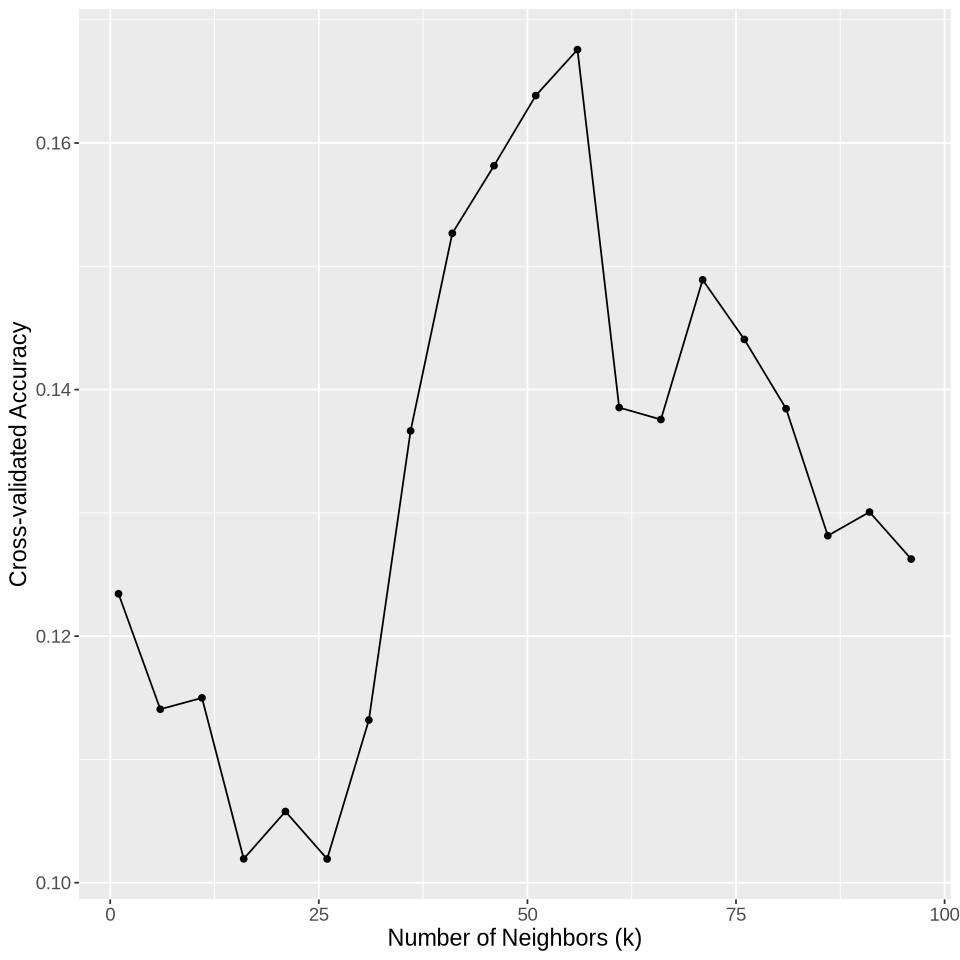

In [5]:
# Split the data 
data_split <- initial_split(polished_data, prop = 0.7, strata = start_day_of_week)
training_set <- training(data_split)
testing_set <- testing(data_split)

# Set up recipe
knn_recipe <- recipe(start_day_of_week ~ Age + gender + experience, data = training_set)

# KNN model specification with tuning
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Cross-validation
knn_vfold <- vfold_cv(training_set, v = 5, strata = start_day_of_week)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# Tuning
knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = knn_vfold, grid = k_vals) |>
  collect_metrics()

# Plot accuracy
knn_accuracy <- knn_results |>
  filter(.metric == "accuracy")

#Visualizing the best k
cross_val_plot <- knn_accuracy |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (k)", y = "Cross-validated Accuracy") +
  theme(text = element_text(size = 14))
cross_val_plot

# Select best k
best_k <- knn_accuracy |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)


##### Final Model Fit and Evaluation

In [6]:
# Train with best k
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

final_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(final_knn_spec)|>
  fit(data = training_set)

# Predict and evaluate using test set
predictions <- predict(final_fit, testing_set) |>
  bind_cols(testing_set)

conf_mat <- conf_mat(predictions, truth = start_day_of_week, estimate = .pred_class)
accuracy <- accuracy(predictions, truth = start_day_of_week, estimate = .pred_class)

conf_mat
accuracy

           Truth
Prediction  Sunday Monday Tuesday Wednesday Thursday Friday Saturday
  Sunday         0      0       0         0        0      0        0
  Monday        17     18      18        22       24     13       26
  Tuesday        5      3       0         1        1      1        5
  Wednesday      6      8       6        10        8      5       10
  Thursday      11      5       6         8        9     10        3
  Friday        21     19      19        15       17     17       16
  Saturday      15     10      13         7        8      9       19

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.1573276


The confusion matrix shows that the model has difficulty distinguishing between days, with most predictions leaning heavily toward Friday regardless of the true class

### Discussion 
My aim was to predict the day of the week a player would be active based on their age, gender and experience. The KNN classification model did not perform well as it reported an accuracy of ~ 9%. These results were not what I expected when formulating the predictive question. This could be due to a number of reasons. One of the reasons could be that age and experience level alone are  not strong predictors of what day someone plays. Some days had more play sessions recorded than others which could have influenced my model while training. A better model choice than KNN classification in the future could suit this analysis. 

References - 
1. IBM. (2021, September 21). Data science: Transforming the future with artificial intelligence. IBM. Retrieved June 20, 2025, from https://www.ibm.com/think/topics/data-science
2. Peng, R. D. (2022). Introduction to data science. Johns Hopkins Bloomberg School of Public Health.
3. Tidyverse. (2024, December 8). Get/set days component of a date-time. lubridate. https://lubridate.tidyverse.org/reference/day.html
4. Whitehead, R. (2024, May 23). Role of data science in the gaming industry. I.O.A. Global. Retrieved June 20, 2025, from https://ioaglobal.org/blog/role-of-data-science-in-gaming-industry/
